In [1]:
import numpy as np
import scipy.stats
import scipy.ndimage.filters
import matplotlib.pyplot as plt
from _glm_hmm import GLMHMMEstimator
from scipy.io import loadmat

In [2]:
num_samples = 5
num_states = 2
num_emissions = 2
num_feedbacks = 3
num_filter_bins = 30
num_steps = 1
filter_offset = 1

In [3]:
tau = 4
total_time = 10000
noiseSD = 0.1
stim_scale = 1
num_real_states = 2

In [4]:
stim = []
states = []
output_stim = []
output_trace = []

In [5]:
for ns in range(0, num_samples):
    output = np.zeros((num_real_states, total_time))
    
    stim_temp = np.zeros((num_filter_bins, total_time + num_filter_bins - 1, num_feedbacks))
    stim_temp[0, :, :] = scipy.ndimage.filters.gaussian_filter(np.random.randn(total_time + num_filter_bins - 1, num_feedbacks), stim_scale)

    for i in range(1, num_filter_bins):
        stim_temp[i, 0:total_time, :] = stim_temp[0, i:(total_time + i), :]
    
    stim.append(stim_temp[:, 0:total_time, :] + np.random.randn(num_filter_bins, total_time, num_feedbacks) * noiseSD)
    filt = scipy.stats.gamma.pdf(np.linspace(0, num_filter_bins), a = tau)[0:num_filter_bins]

    p1 = np.exp(np.matmul(stim[ns][:, :, 0].T, filt.T) + np.matmul(stim[ns][:, :, 1].T, -filt.T))
    output[0, :] = p1 / (1 + p1) > 0.5
    p2 = np.exp(np.matmul(stim[ns][:, :, 0].T, -filt.T) + np.matmul(stim[ns][:, :, 1].T, filt.T))
    output[1, :] = p2 / (1 + p2) > 0.5

    p3 = np.exp(np.matmul(stim[ns][:, :, 2].T, filt.T))
    states.append(p3 / (1 + p3) > 0.5)

    output_trace.append(np.zeros(total_time))
    for ss in range(0, num_real_states):
        output_trace[ns][states[ns] == ss] = output[ss][states[ns] == ss]

    final_stim = np.append(stim[ns][:, :, 0], stim[ns][:, :, 1], axis = 0)
    final_stim = np.append(final_stim, stim[ns][:, :, 2], axis = 0)
    final_stim = np.append(final_stim, np.ones((1, total_time)), axis = 0)
    output_stim.append(final_stim)

In [6]:
estimator = GLMHMMEstimator(num_samples = num_samples, num_states = num_states, num_emissions = num_emissions, num_feedbacks = num_feedbacks, num_filter_bins = num_filter_bins, num_steps = num_steps, filter_offset = filter_offset)
estimator.fit(output_stim, output_trace, [])
estimator.predict(output_stim)

Fitting iteration:   1
Fitting categorical emission filters
0.3475791746915433
0.3475791746915433
0.3341450917984206
0.2884693695258541
0.247742278454394
0.2427054563241582
0.24231918083010137
0.2409715733644828
0.2383532615286656
0.237548881898656
0.23749315958747277
0.23739638747476793
0.23722470720947333
0.2369274260862253
0.23646118955553797
0.2360211130965154
0.23582957790879966
0.2356932550114155
0.23561402283675376
0.23548257995257757
0.23525562957373616
0.23486301685479316
0.23421950361451593
0.233355802137391
0.23290536615015234
0.232589046091515
0.23243559386256554
0.23219606047917418
0.2318327560845318
0.23144752170459149
0.23125110087603526
0.2311892868164578
0.231155799548851
0.23110159617313694
0.23101897344386252
0.230942300271383
0.23091178319518182
0.23089898909837528
0.23088847514530678
0.2308709821636098
0.23084350779926122
0.23081519421636043
0.23080499345166783
0.23080049345408962
0.23079800670925896
0.23079381818910322
0.2307870402324431
0.23077839419278062
0.2307

0.347640935596374
Optimization terminated successfully.
         Current function value: 0.347641
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
Fitting state transition filters
0.19411536748706976
0.4930514408521363
0.792906558229772
1.0910733846394178
1.3900094130148724
1.6889454863799394
1.9907669879261183
2.288656291509855
2.5869458942231036
2.8854972609979526
3.1842102633574347
3.483019446847094
3.7818843992090807
4.080781074320186
4.379695529752134
4.6786198347650885
4.977549544265705
5.276482195855442
         Current function value: 0.493051
         Iterations: 0
         Function evaluations: 17
         Gradient evaluations: 5
0.24945396792982844
0.5778023695025274
0.8936485816821323
1.2341393013898407
1.5624927914058135
1.8908411929787725
2.2191895945514717
2.5051200252915136
2.851340501699351
3.1901159882135985
3.5244250692772803
3.8561277814782637
4.186340424282014
4.51571451453287
4.844622550750167
5.173274166366247
5.50178587371

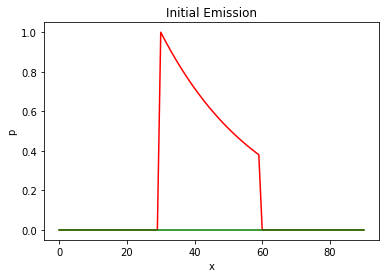

In [7]:
plt.figure()
plt.title("Initial Emission")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), estimator.emit_w_init_[0, 0, :], "-r")
plt.plot(range(0, 91), estimator.emit_w_init_[1, 0, :], "-g")
plt.show()

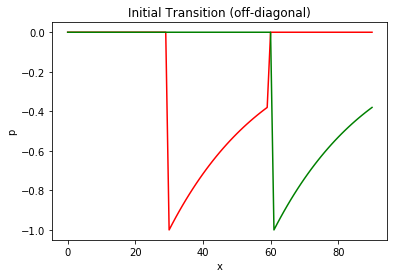

In [8]:
plt.figure()
plt.title("Initial Transition (off-diagonal)")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), estimator.trans_w_init_[0, 1, :], "-r")
plt.plot(range(0, 91), estimator.trans_w_init_[1, 0, :], "-g")
plt.show()

In [9]:
data = loadmat('GLMHMM_output.mat')
emit_w_final = data['output'][0][-1]['emit_w'][0][0]
trans_w_final = data['output'][0][-1]['trans_w'][0][0]
print(emit_w_final.shape)
print(trans_w_final.shape)

(2, 1, 91)
(2, 2, 91)


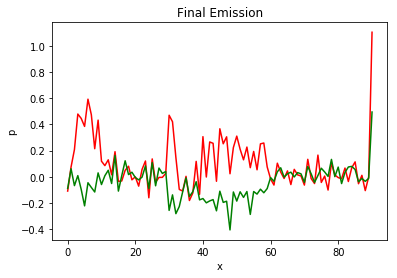

In [10]:
plt.figure()
plt.title("Final Emission")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), emit_w_final[0, 0, :], "-r")
plt.plot(range(0, 91), emit_w_final[1, 0, :], "-g")
plt.show()

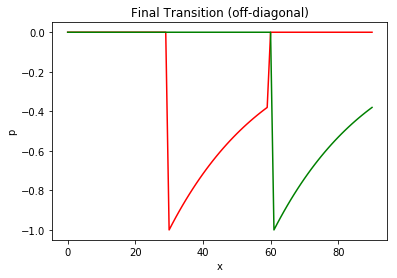

In [11]:
plt.figure()
plt.title("Final Transition (off-diagonal)")
plt.xlabel("x")
plt.ylabel("p")
plt.plot(range(0, 91), trans_w_final[0, 1, :], "-r")
plt.plot(range(0, 91), trans_w_final[1, 0, :], "-g")
plt.show()